## <font color=blue> IMPORTING LIBRARIES </font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib import rcParams
import pandas as pd
import glob, os
from sklearn.ensemble import RandomForestRegressor

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## <font color=blue> DATA ANALYSIS </font>

In [2]:
input_path = 'Data_Extract'
output_path_excel = 'Data_Full'
output_path_image = 'Image_Full'

In [3]:
def load_and_process_data(excel_file, excel_data_path, full_time_range):
    df = pd.read_excel(excel_data_path + excel_file)
    df = df.set_index("Timestamp").reindex(full_time_range).reset_index().rename(columns={"index": "Timestamp"})
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
    return df

In [4]:
def get_standard_settings(substance, standard):
    return standard.get(substance, None)

In [5]:
def plot_main_chart(df, ax_main, substance):
    valid_mask = df["Value"].notna().values
    missing_mask = df["Value"].isna().values
    valid_data = df.loc[valid_mask]
    ax_main.bar(valid_data["Timestamp"], valid_data["Value"], color="orange", width=1/24, alpha=0.7, bottom=0)
    missing_value = df["Value"].isna().sum()
    ax_main.text(0.97, 0.9, f"Missing Value: {missing_value}", transform=ax_main.transAxes, ha="right", fontsize=14, color="black")
    ax_main.set_ylabel(f"{substance}", labelpad=20, rotation=0, va='center', ha='right', wrap=True, fontsize=18)
    ax_main.xaxis.set_major_locator(MonthLocator())
    ax_main.xaxis.set_major_formatter(DateFormatter("%b"))
    ax_main.set_xlabel(None)

In [6]:
def plot_quality_bars(df, ax_rect, target, topic, safe_mask, dangerous_mask, missing_mask):
    ax_rect.bar(df.loc[missing_mask, "Timestamp"], [1] * missing_mask.sum(), color="violet", alpha=0.7, width=1/24, label="Missing Hours")
    ax_rect.bar(df.loc[safe_mask, "Timestamp"], [1] * safe_mask.sum(), color="green", alpha=0.7, width=1/24, label="Good Quality Hours")
    if target is not None:
        ax_rect.bar(df.loc[dangerous_mask, "Timestamp"], [1] * dangerous_mask.sum(), color="red", alpha=0.7, width=1/24, label="Bad Quality Hours")
    ax_rect.set_yticks([])
    ax_rect.set_ylim(0, 1)
    ax_rect.set_ylabel(topic, labelpad=20, rotation=0, va='center', ha='right', wrap=True, fontsize=18)
    ax_rect.set_xlabel("Date")
    ax_rect.xaxis.set_major_locator(MonthLocator())
    ax_rect.xaxis.set_major_formatter(DateFormatter("%b"))

In [7]:
def save_dangerous_data(df_dangerous, substance, USGS, station, topic):
    if topic:
        df_dangerous.to_excel(f"{input_path}/Data_Output/{substance}_{USGS}_{station}_{topic}_Dangerous.xlsx", index=False)
    else:
        df_dangerous.to_excel(f"{input_path}/Data_Output/{substance}_{USGS}_{station}_Dangerous.xlsx", index=False)

In [8]:
def process_file(excel_file, excel_data_path, full_time_range, standard):
    # Extract information from file name
    parts = excel_file.split('.xlsx')[0].split('_')
    substance = parts[0]
    USGS = parts[1]
    station = '_'.join(parts[2:])
    print(substance, USGS, station)

    # Get substance-specific settings
    settings = get_standard_settings(substance, standard)
    if not settings:
        return

    targets = settings["targets"]
    topics = settings["topics"]
    greater = settings["greater"]
    
    # Load and process data
    df = load_and_process_data(excel_file, excel_data_path, full_time_range)
    
    # Create the plot
    fig, axes = plt.subplots(len(targets) + 1, 1, figsize=(18, 6), sharex=True, gridspec_kw={"height_ratios": [10] + [2] * len(targets), "hspace": 0.1})
    ax_main = axes[0]
    plot_main_chart(df, ax_main, substance)
    
    # Plot quality bars for each target
    for i in range(len(targets)):
        target = targets[i]
        topic = topics[i]
        
        if isinstance(target, list):
            safe_mask = (df["Value"] >= target[0]) & (df["Value"] <= target[1])
            dangerous_mask = (df["Value"] < target[0]) | (df["Value"] > target[1])
        elif target is not None:
            safe_mask = (df["Value"] >= target) if greater else (df["Value"] < target)
            dangerous_mask = (df["Value"] < target) if greater else (df["Value"] >= target)
        else:
            safe_mask = df["Value"].notna()
            dangerous_mask = []

        ax_rect = axes[i + 1]
        plot_quality_bars(df, ax_rect, target, topic, safe_mask, dangerous_mask, df["Value"].isna().values)

        # Save dangerous data
        df_dangerous = df.loc[dangerous_mask]
        save_dangerous_data(df_dangerous, substance, USGS, station, topic)
    
    # Finalizing the plot
    fig.legend(
        handles=[
            plt.Line2D([0], [3], color="violet", lw=4, label="Missing Hours"),
            plt.Line2D([0], [3], color="green", lw=4, label="Good Quality Hours"),
            plt.Line2D([0], [3], color="red", lw=4, label="Bad Quality Hours"),
            plt.Line2D([0], [3], color="orange", lw=4, label=f"{substance} Value"),
        ],
        loc="upper center",
        ncol=4,
        bbox_to_anchor=(0.5, 1),
        fontsize=15,
        frameon=False,
    )
    fig.suptitle(f"{substance} Quality at {USGS} Station {station}", fontsize=20, y=1.05)
    plt.show()
    fig.savefig(f'{input_path}/Image_Output/{substance}_{USGS}_{station}.jpg', format='jpg', dpi=500)

In [9]:
def process_all_files(excel_data_path, standard, full_time_range):
    for excel_file in os.listdir(excel_data_path):
        print(excel_file)
        process_file(excel_file, excel_data_path, full_time_range, standard)
        print('-'*100)

In [10]:
standard = {
    "Dissolved oxygen": {
        "targets": [7, 8, 5, 6.5],
        "topics": ["Drinking Water", "Ecology", "Recreation", "Aquaculture"],
        "greater": True
    },
    "pH": {
        "targets": [[6.5, 8.5]],
        "topics": [None],
        "greater": None
    },
    "Temperature": {
        "targets": [None, 18, 28, 25],
        "topics": ["Drinking Water", "Ecology", "Recreation", "Aquaculture"],
        "greater": False
    },
    "Turbidity": {
        "targets": [0.75, 5, 10, 12.5],
        "topics": ["Drinking Water", "Ecology", "Recreation", "Aquaculture"],
        "greater": False
    }
}

In [11]:
full_time_range = pd.date_range(start="2024-01-01", end="2025-01-01", freq="H")
excel_data_path = f'{input_path}/Data_Input/'
# process_all_files(excel_data_path, standard, full_time_range)

14159110 MCKENZIE RIVER ABOVE SOUTH FORK, NEAR RAINBOW  Temperature, water


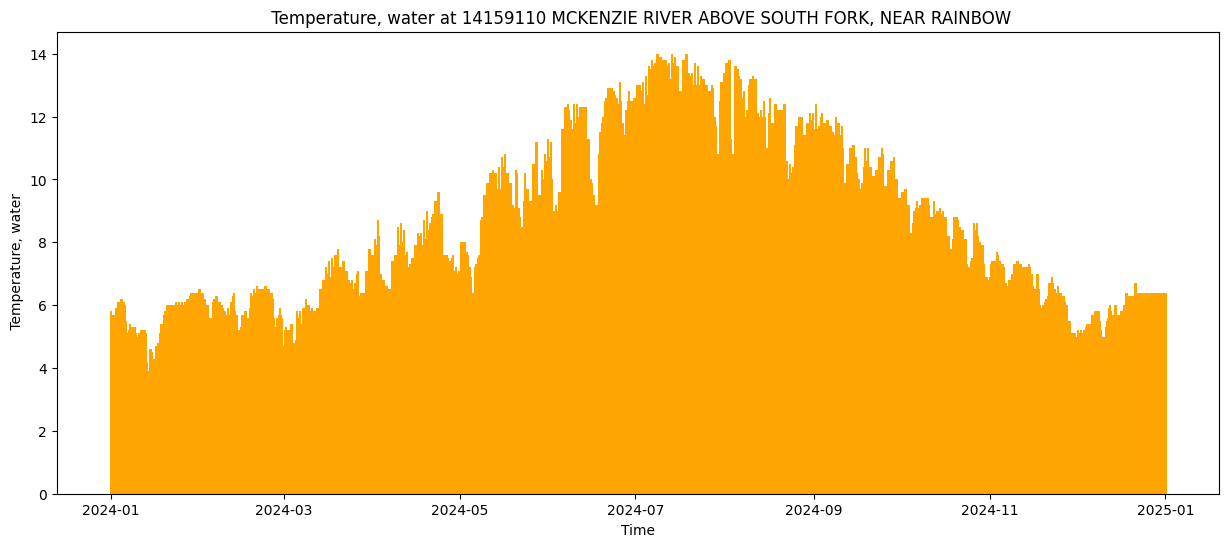

14159500 SOUTH FORK MCKENZIE RIVER NEAR RAINBOW Barometric pressure


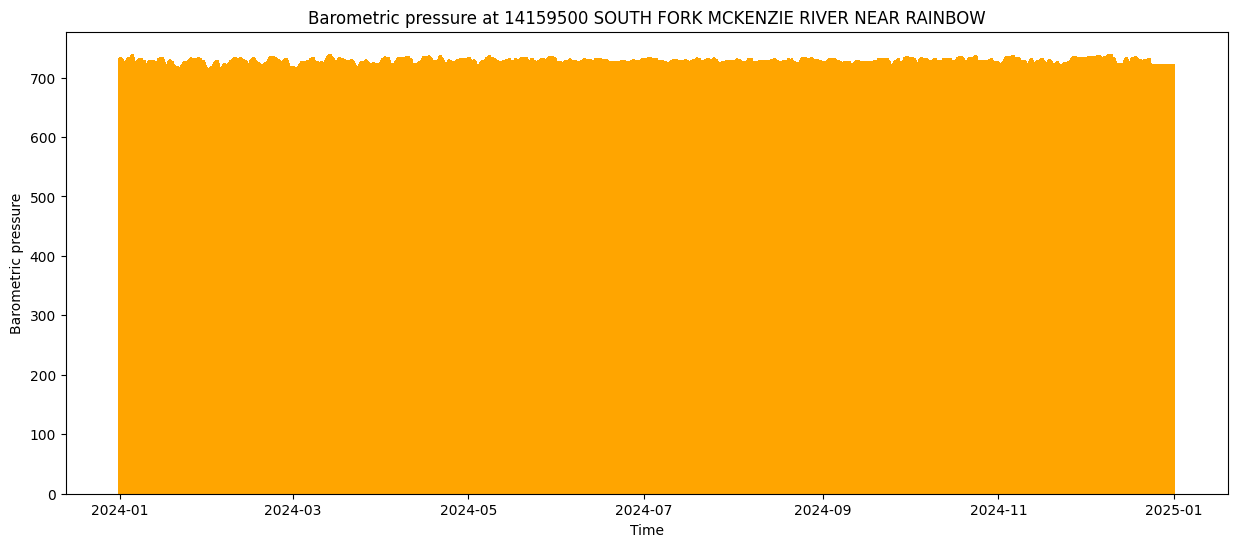

14158500 MCKENZIE RIVER AT OUTLET OF CLEAR LAKE Discharge


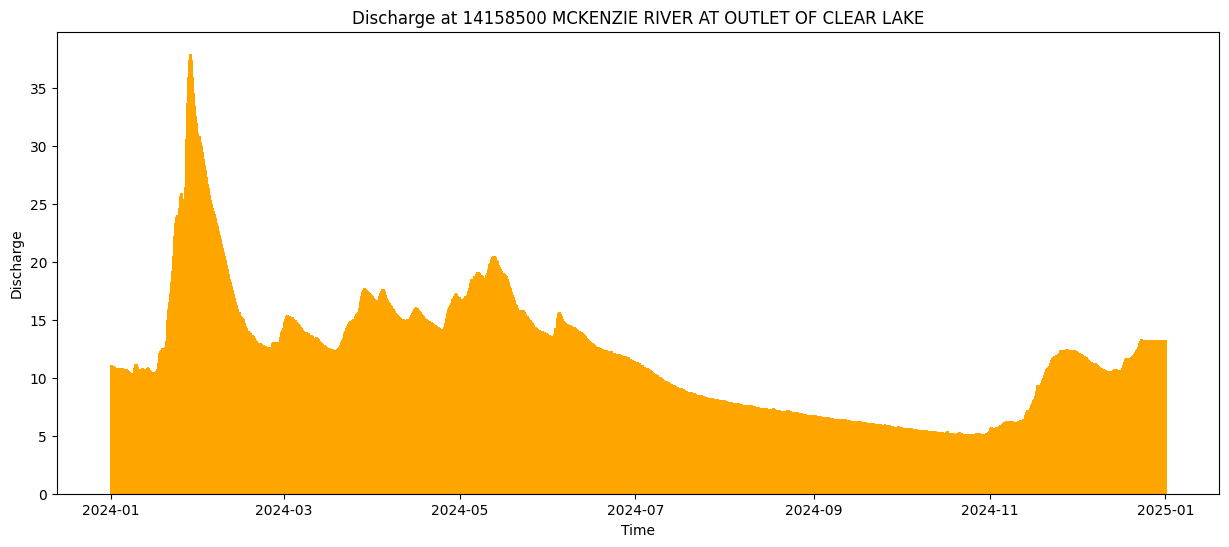

14158740 MCKENZIE RIVER BL PAYNE CR, NR BELKNAP SPRINGS Discharge


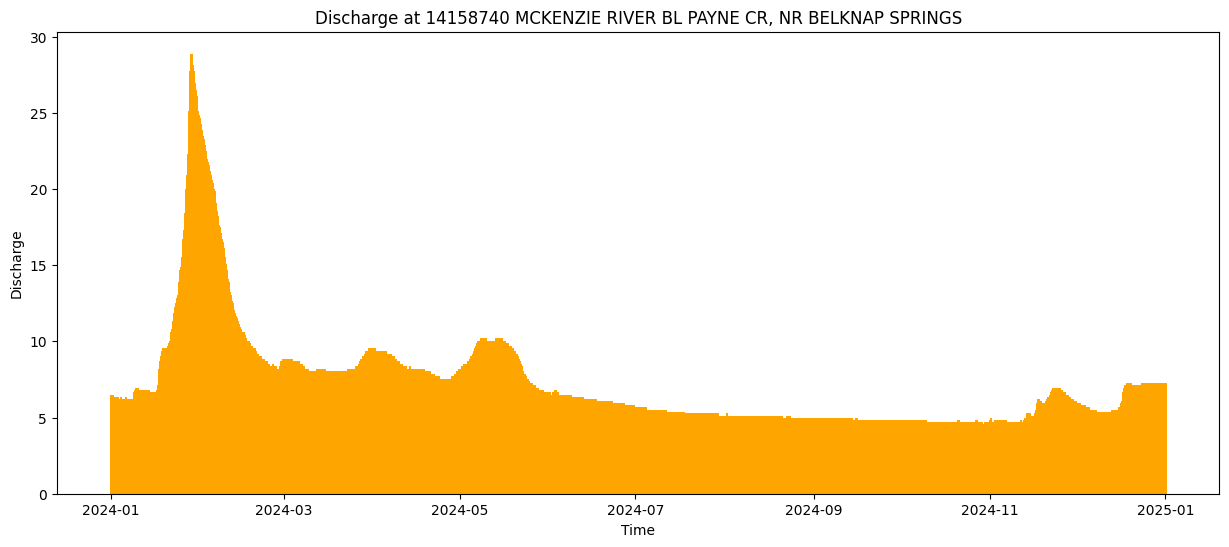

14158850 MCKENZIE R BLW TRAIL BR DAM NR BELKNAP SPRINGS Discharge


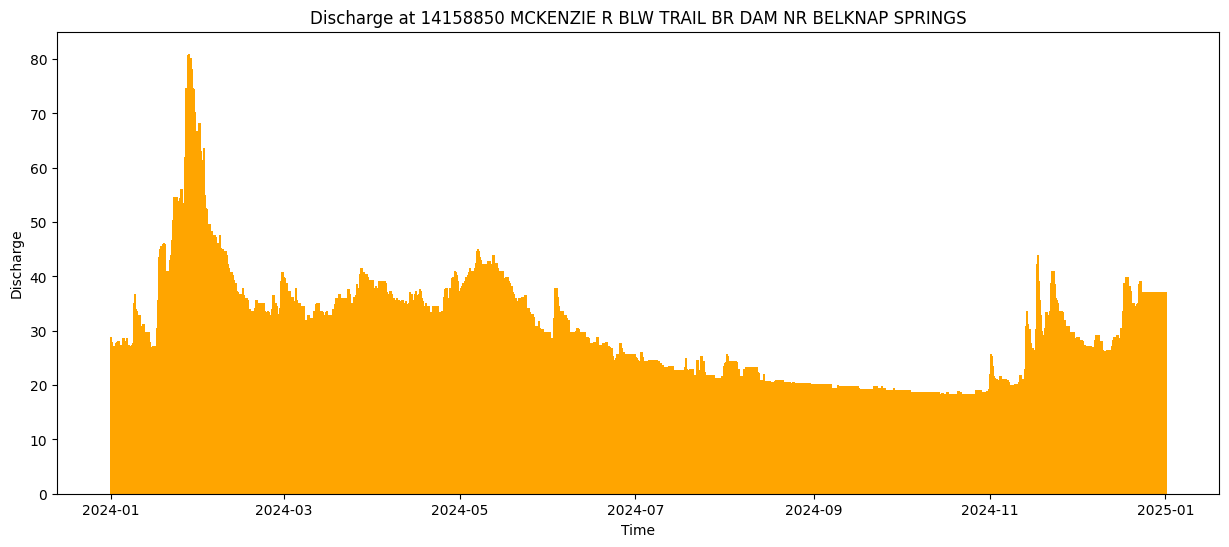

14159200 SO FK MCKENZIE RIVER ABV COUGAR LAKE NR RAINBOW Discharge


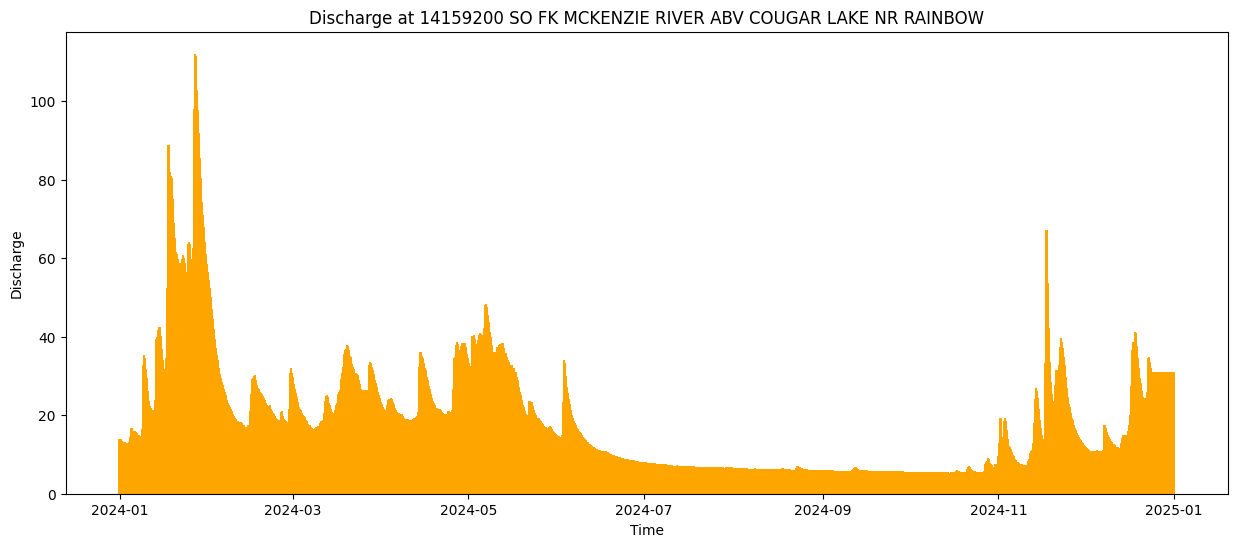

14159500 SOUTH FORK MCKENZIE RIVER NEAR RAINBOW Discharge


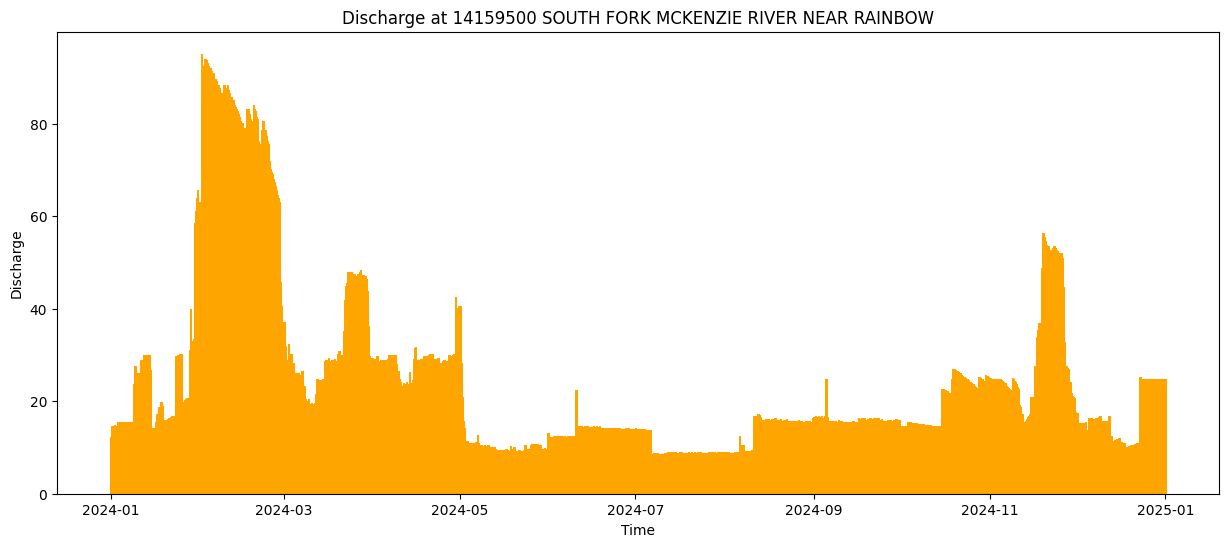

14162500 MCKENZIE RIVER NEAR VIDA Discharge


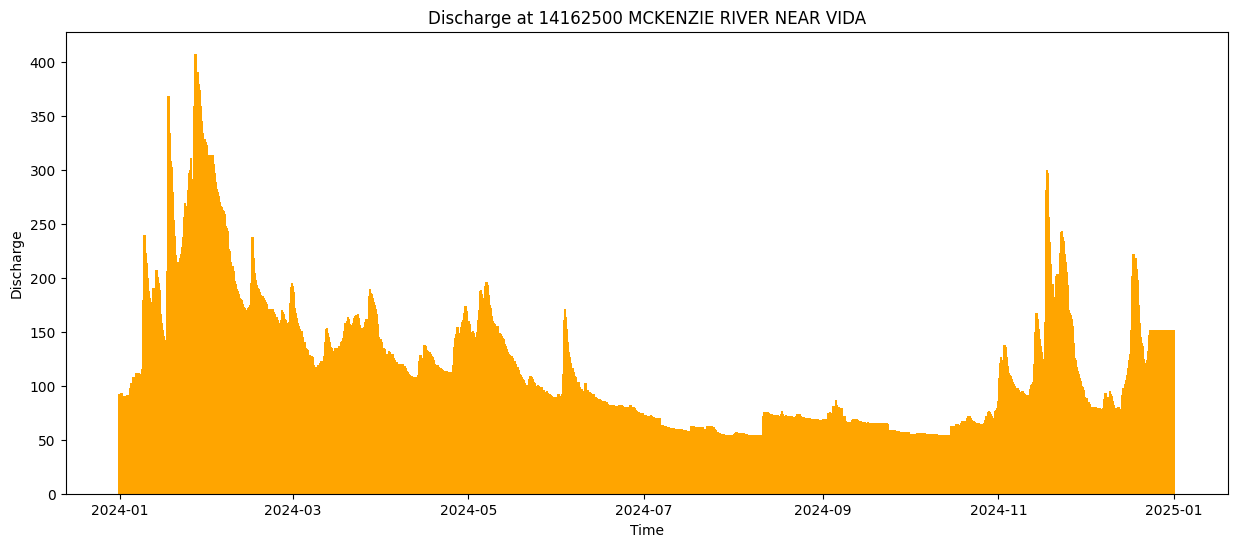

14163150 MCKENZIE RIVER BLW LEABURG DAM, NR LEABURG Discharge


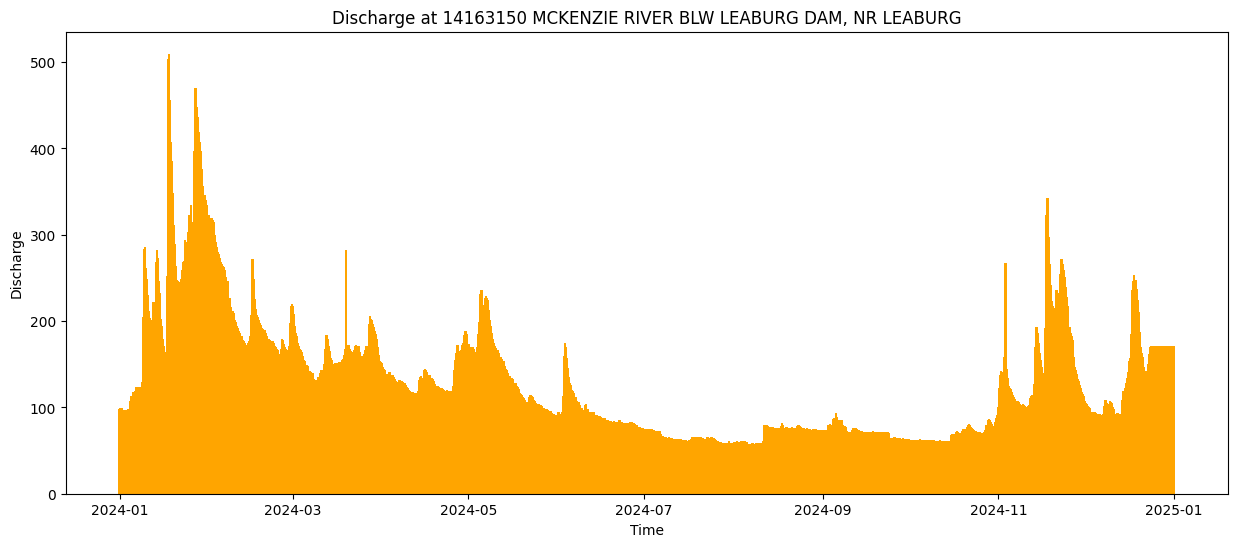

14163900 MCKENZIE RIVER NEAR WALTERVILLE Discharge


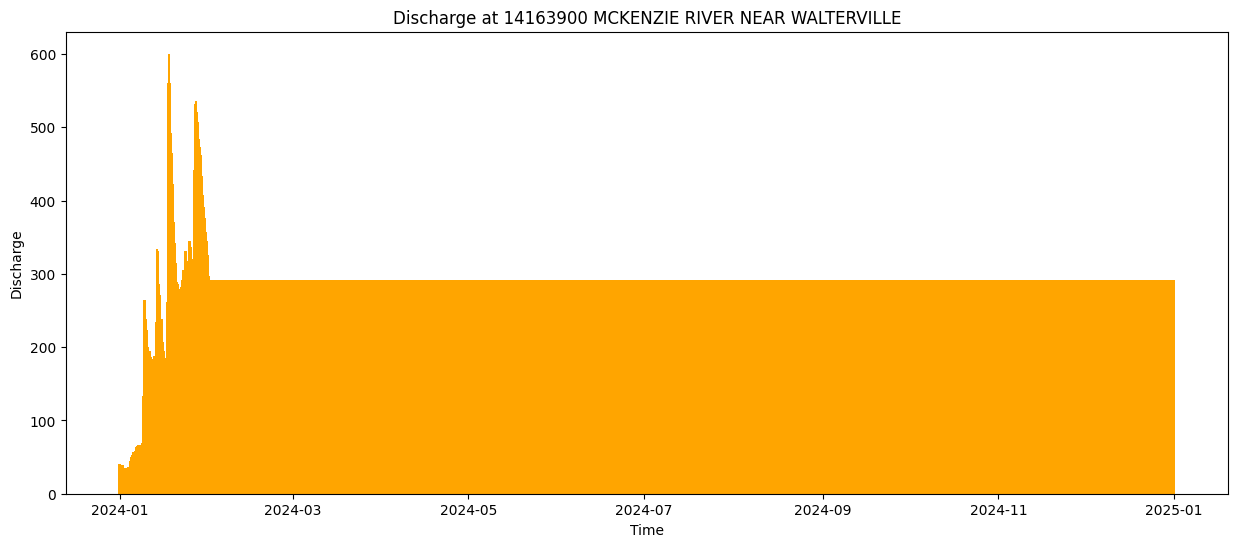

14164900 McKENZIE RIVER ABV HAYDEN BR, AT SPRINGFIELD Discharge


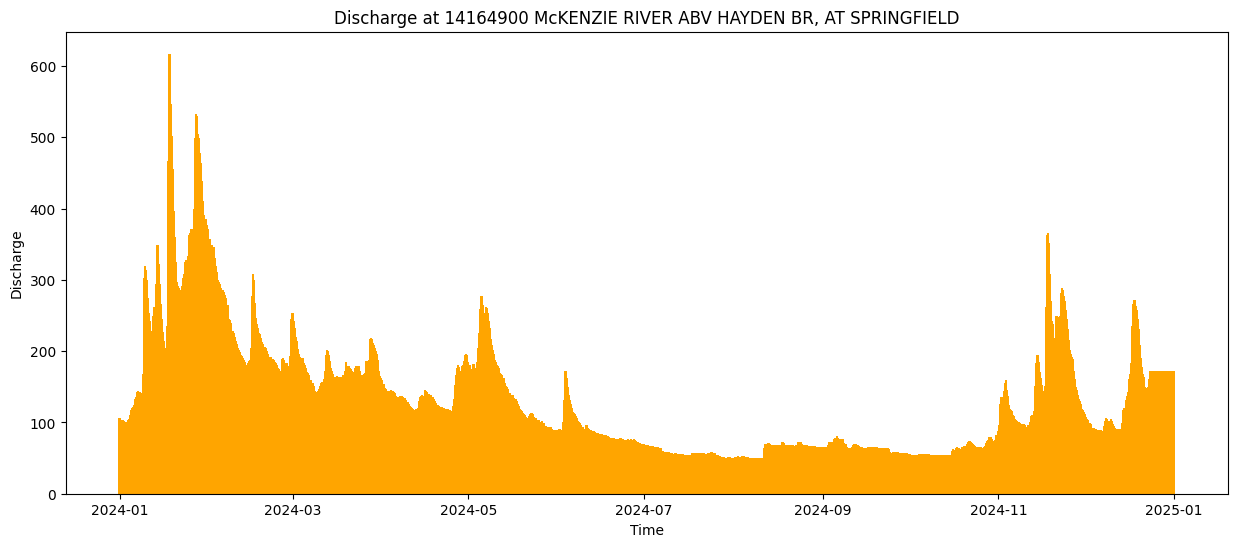

14165500 MCKENZIE RIVER NEAR COBURG Discharge


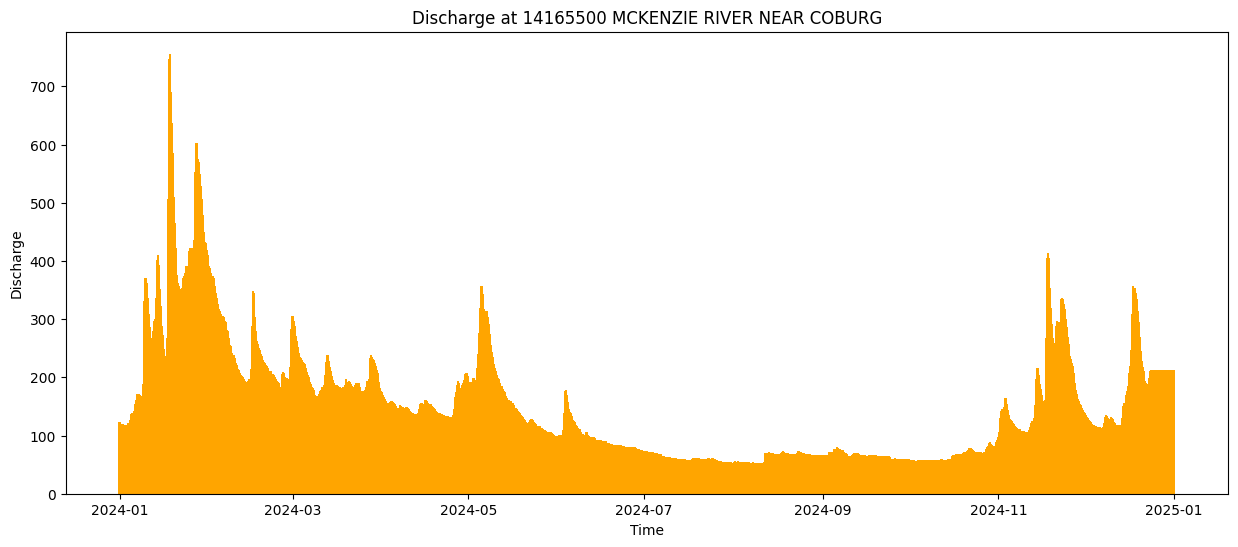

14158850 MCKENZIE R BLW TRAIL BR DAM NR BELKNAP SPRINGS Dissolved oxygen, water, unfiltered


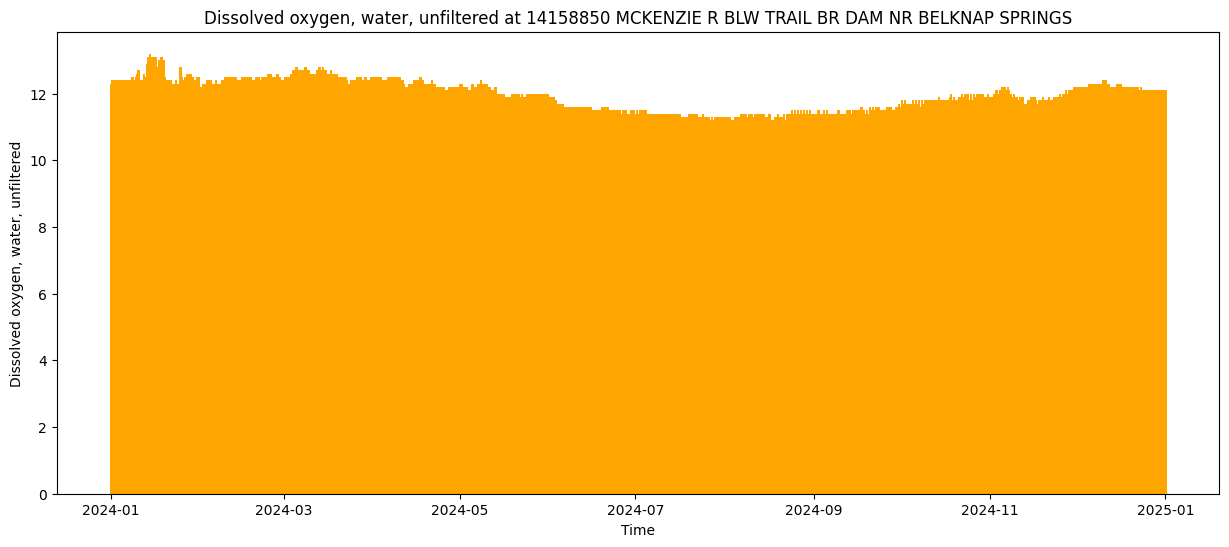

14162500 MCKENZIE RIVER NEAR VIDA Dissolved oxygen, water, unfiltered


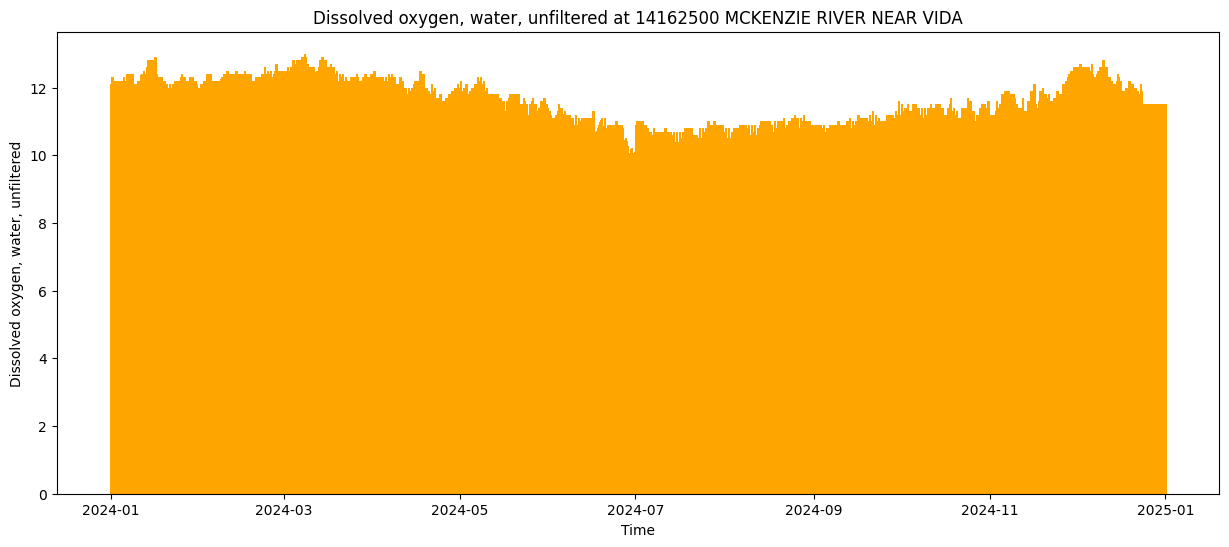

14158500 MCKENZIE RIVER AT OUTLET OF CLEAR LAKE Gage height


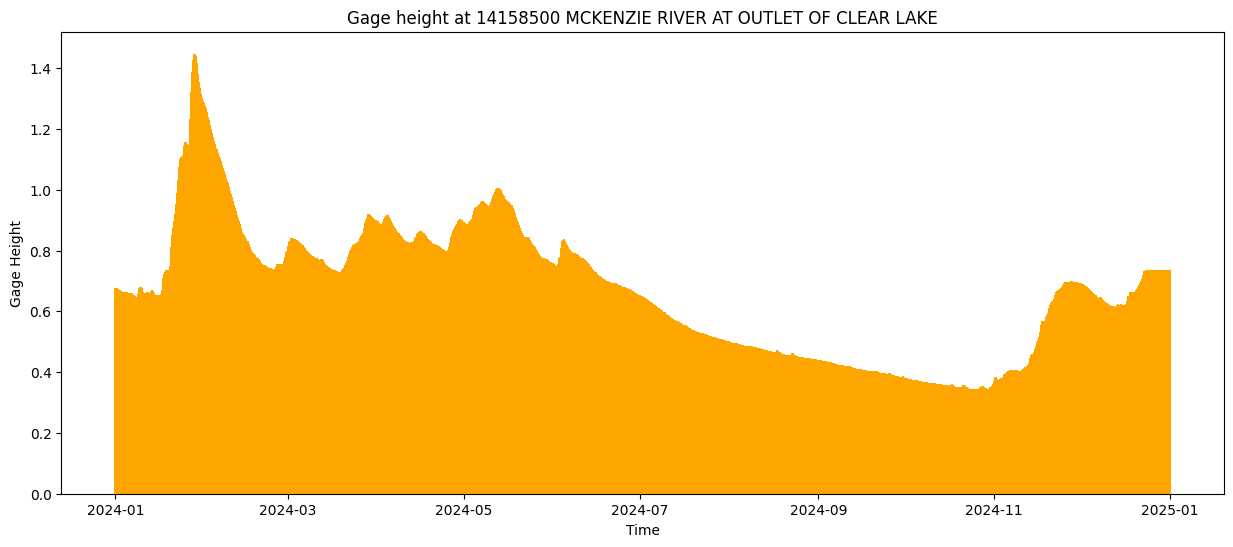

14158740 MCKENZIE RIVER BL PAYNE CR, NR BELKNAP SPRINGS Gage height


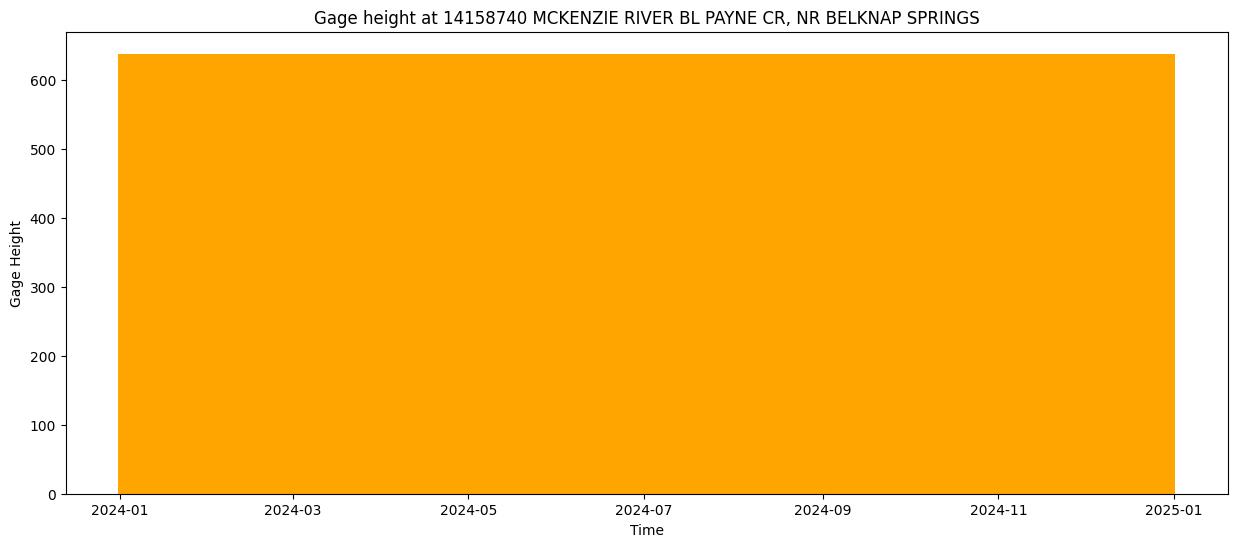

14158850 MCKENZIE R BLW TRAIL BR DAM NR BELKNAP SPRINGS Gage height


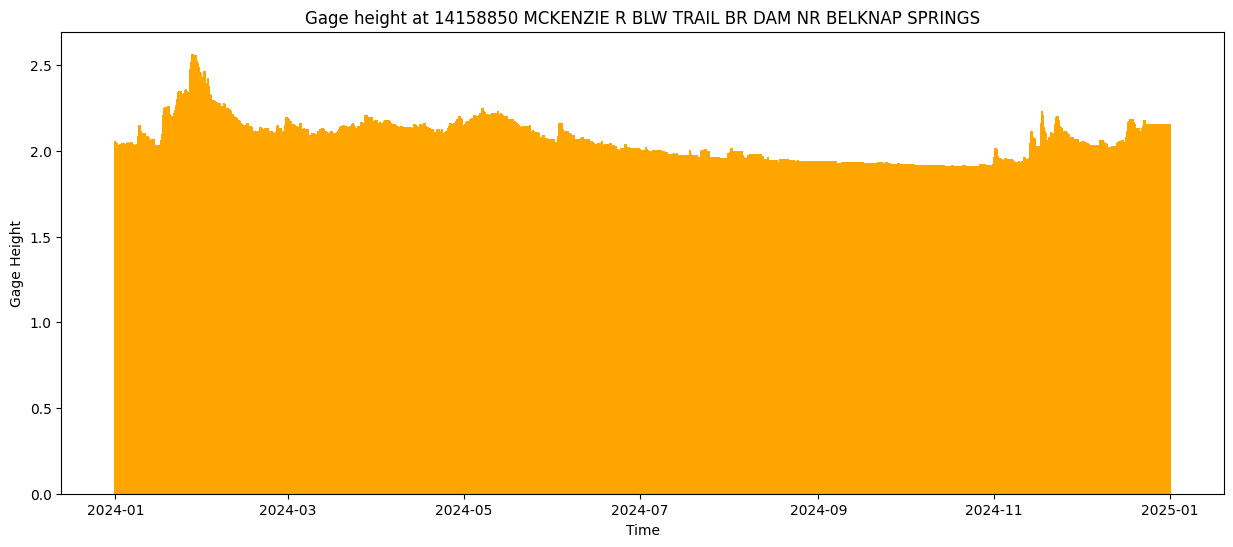

14159110 MCKENZIE RIVER ABOVE SOUTH FORK, NEAR RAINBOW Gage height


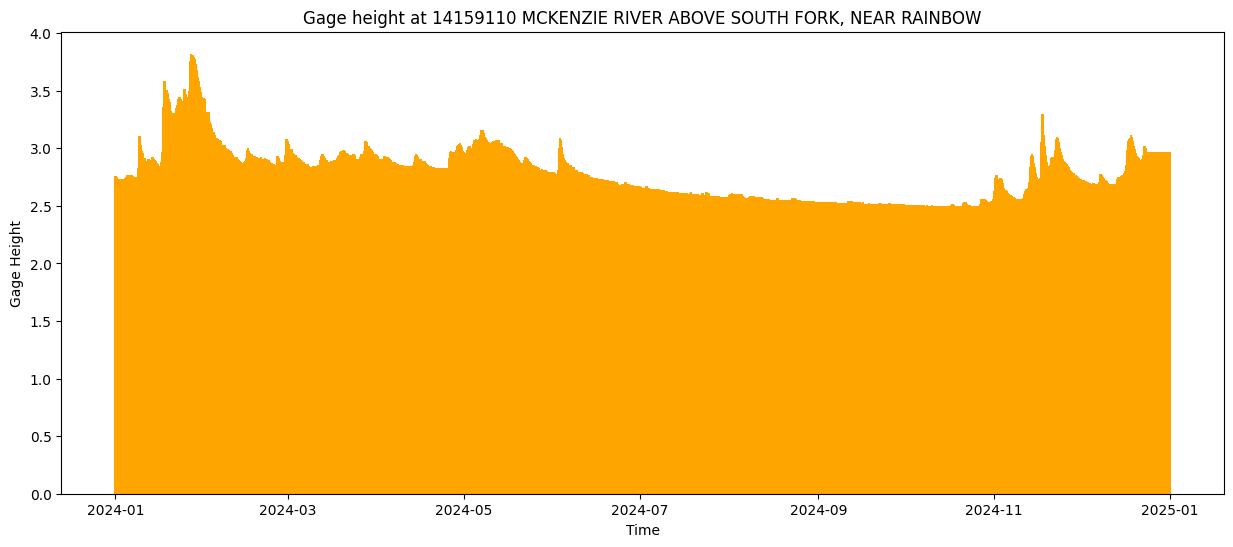

14159130 SF MCKENZIE RIVER ABV ROARING R NR COUGAR DAM Gage height


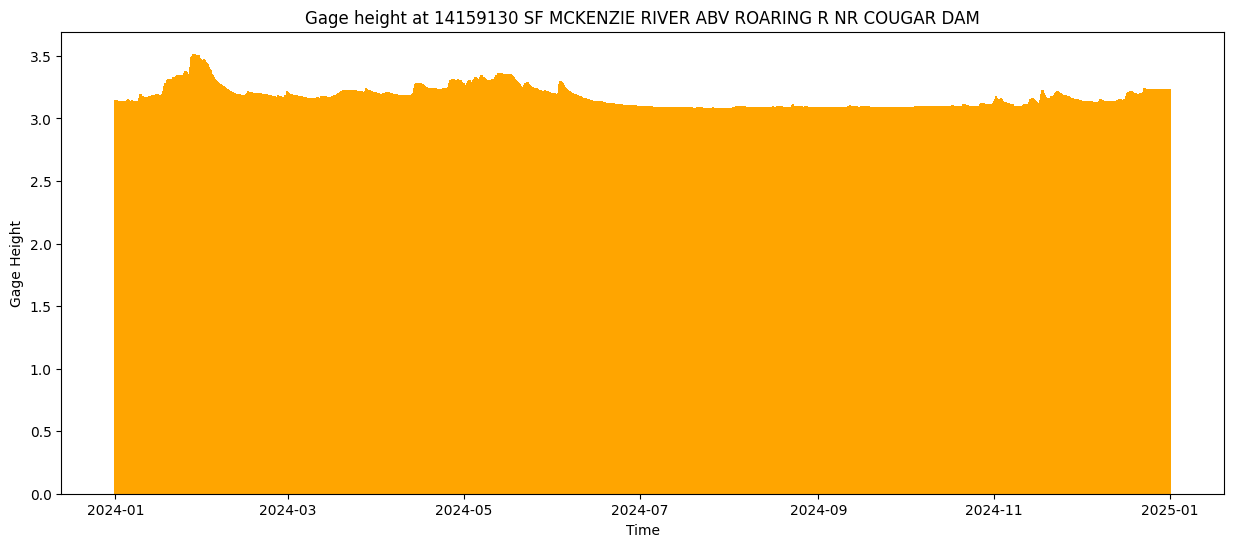

14159200 SO FK MCKENZIE RIVER ABV COUGAR LAKE NR RAINBOW Gage height


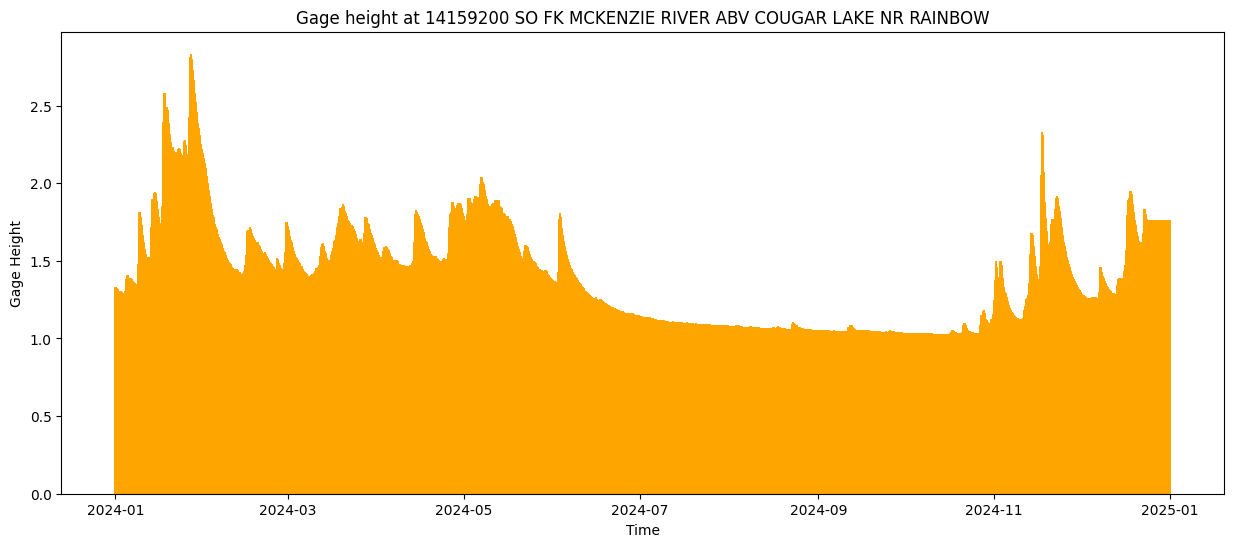

14159500 SOUTH FORK MCKENZIE RIVER NEAR RAINBOW Gage height


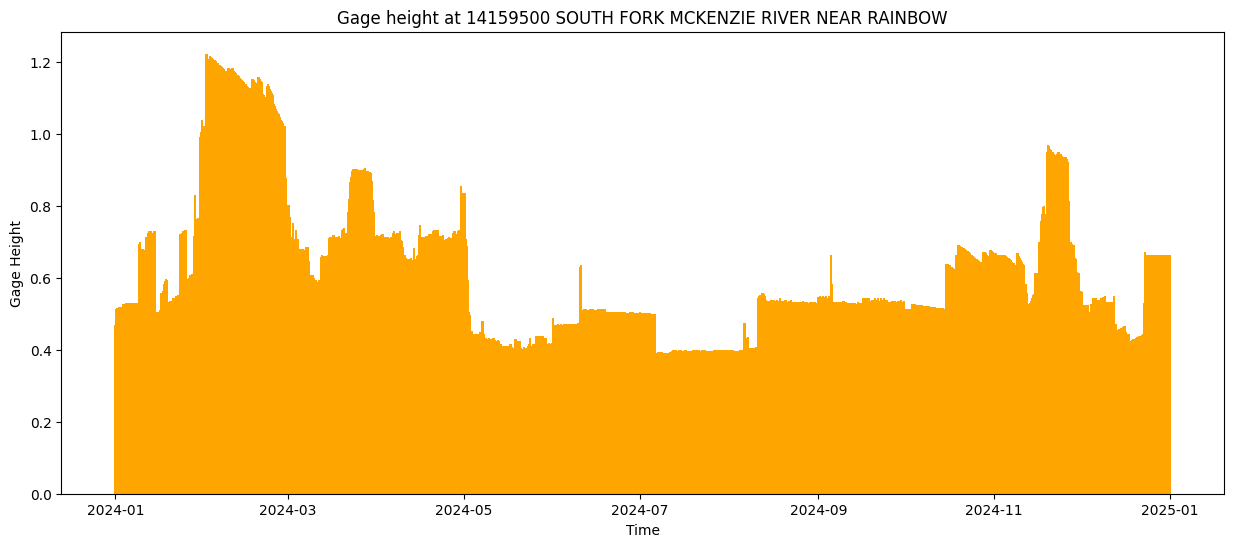

14162500 MCKENZIE RIVER NEAR VIDA Gage height


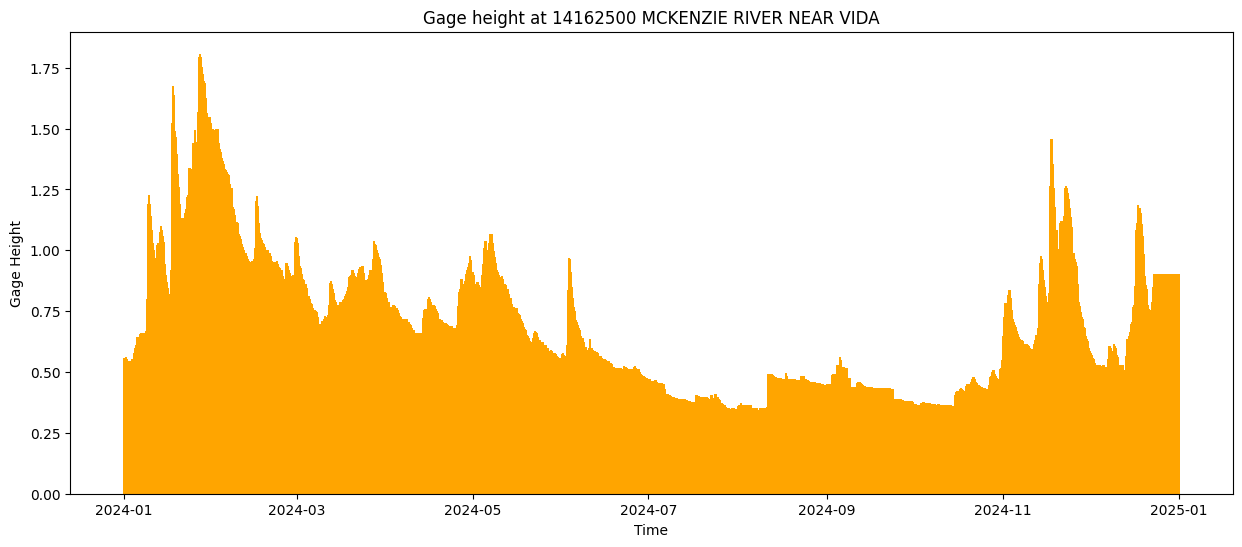

14163150 MCKENZIE RIVER BLW LEABURG DAM, NR LEABURG Gage height


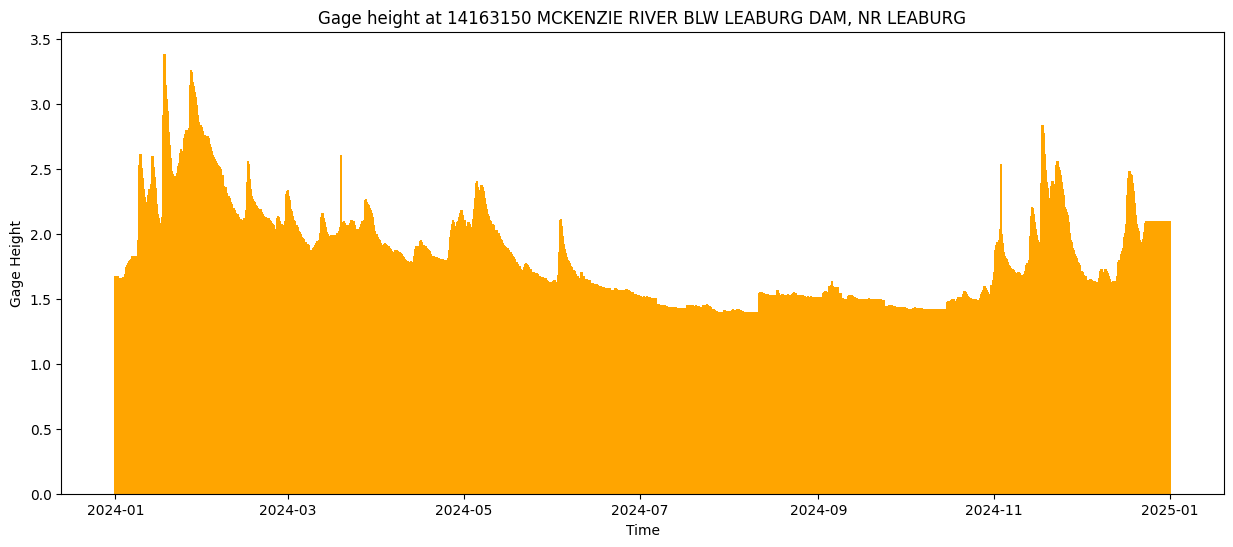

14163900 MCKENZIE RIVER NEAR WALTERVILLE Gage height


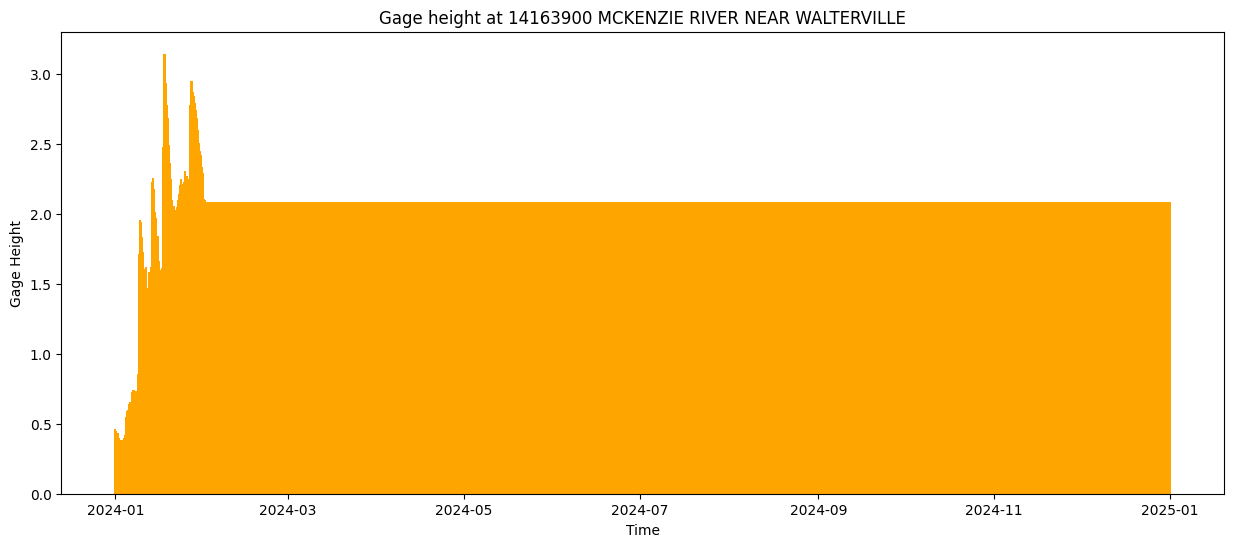

14164900 McKENZIE RIVER ABV HAYDEN BR, AT SPRINGFIELD Gage height


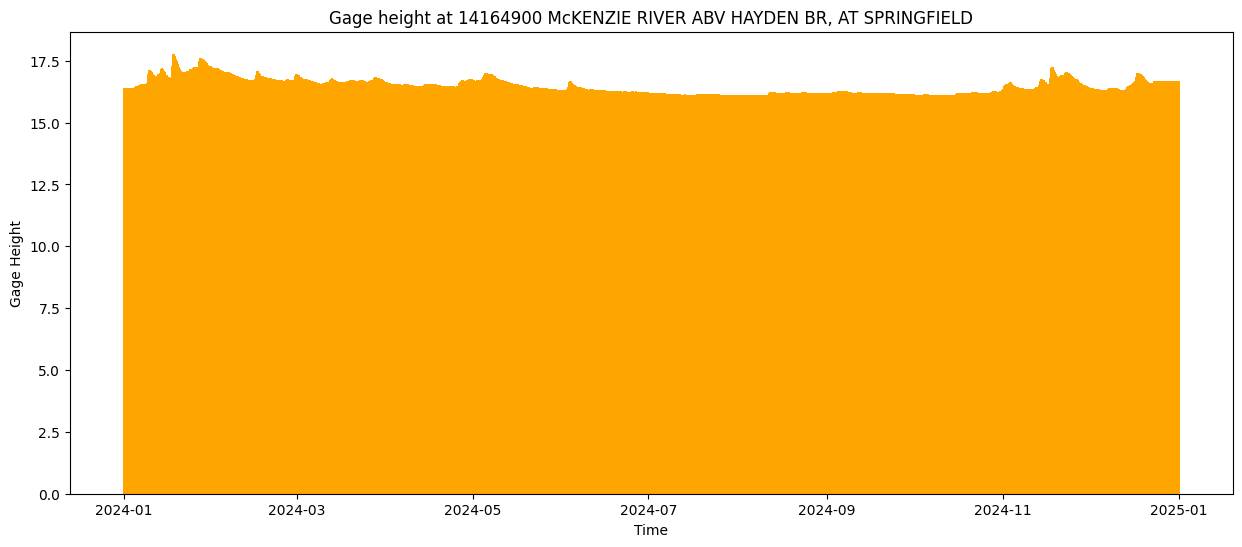

14165500 MCKENZIE RIVER NEAR COBURG Gage height


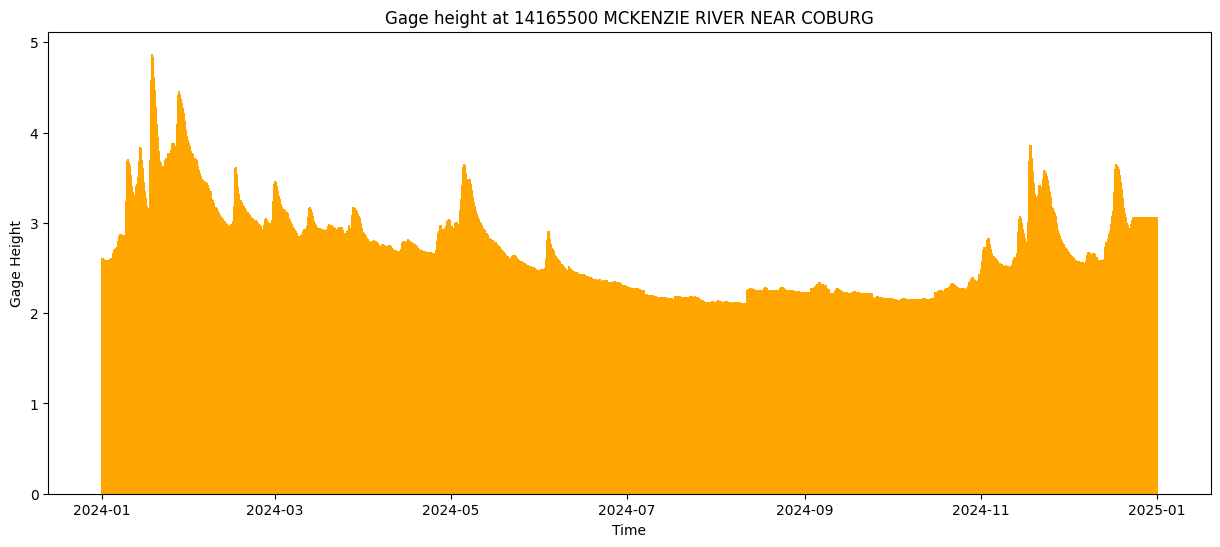

14158850 MCKENZIE R BLW TRAIL BR DAM NR BELKNAP SPRINGS pH, water, unfiltered, field


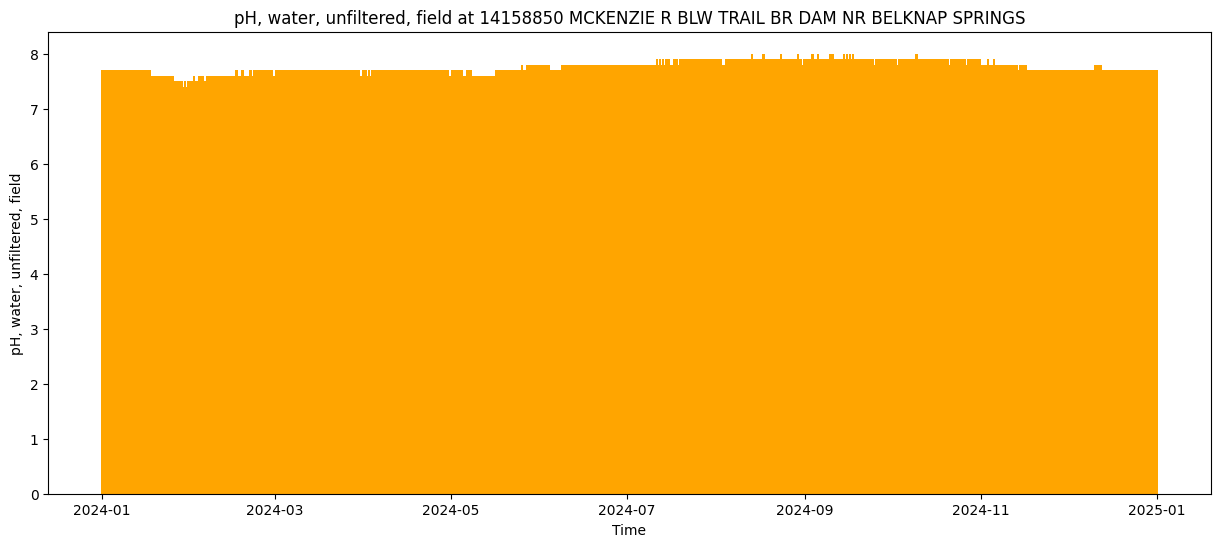

14162500 MCKENZIE RIVER NEAR VIDA pH, water, unfiltered, field


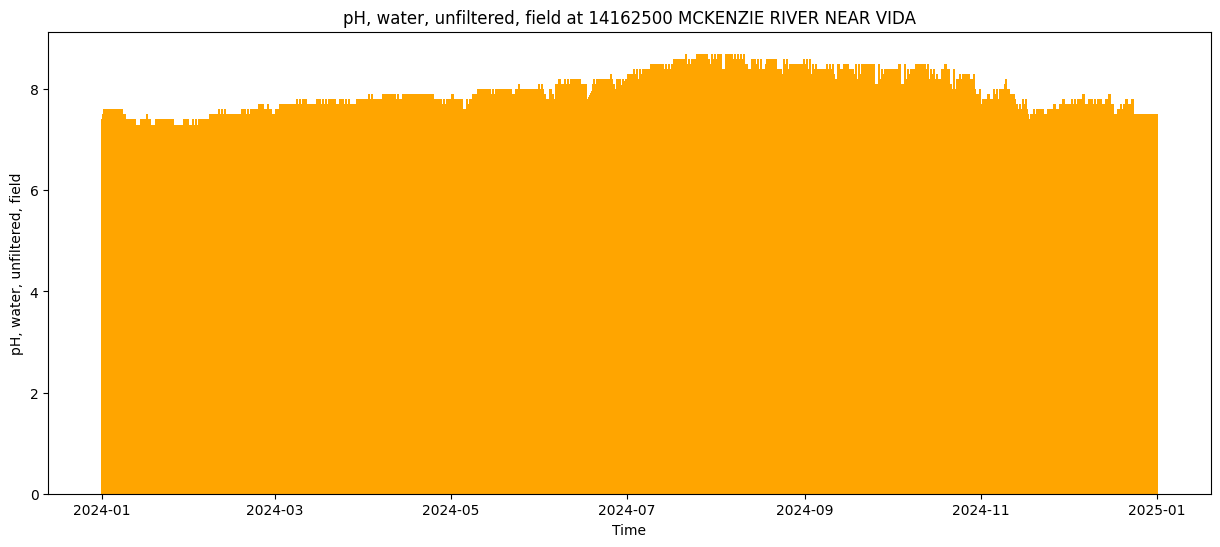

14158500 MCKENZIE RIVER AT OUTLET OF CLEAR LAKE Specific conductance, water, unfiltered


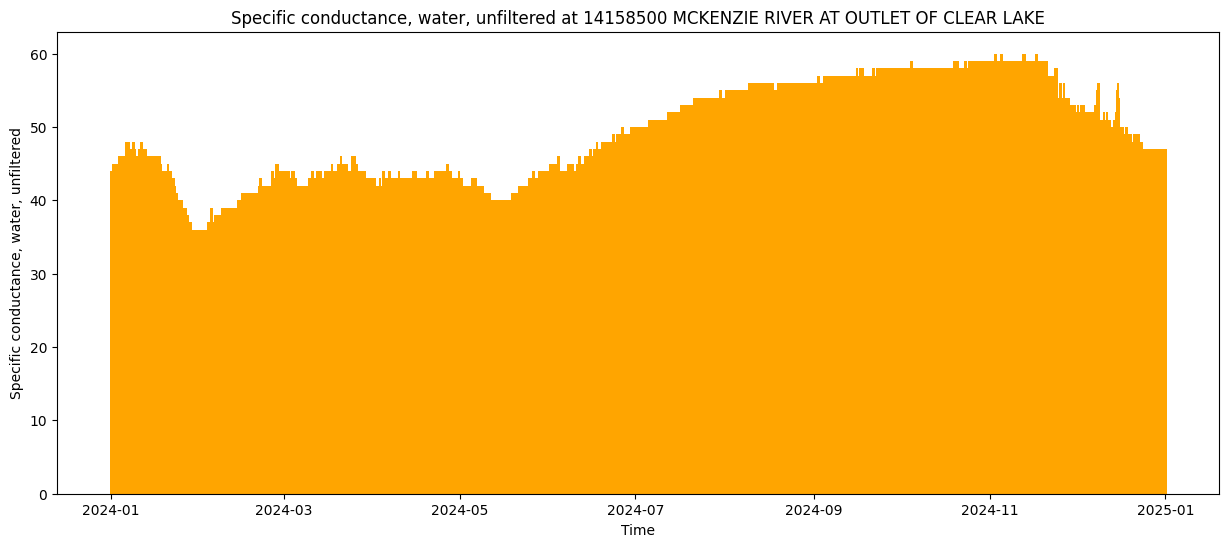

14158740 MCKENZIE RIVER BL PAYNE CR, NR BELKNAP SPRINGS Specific conductance, water, unfiltered


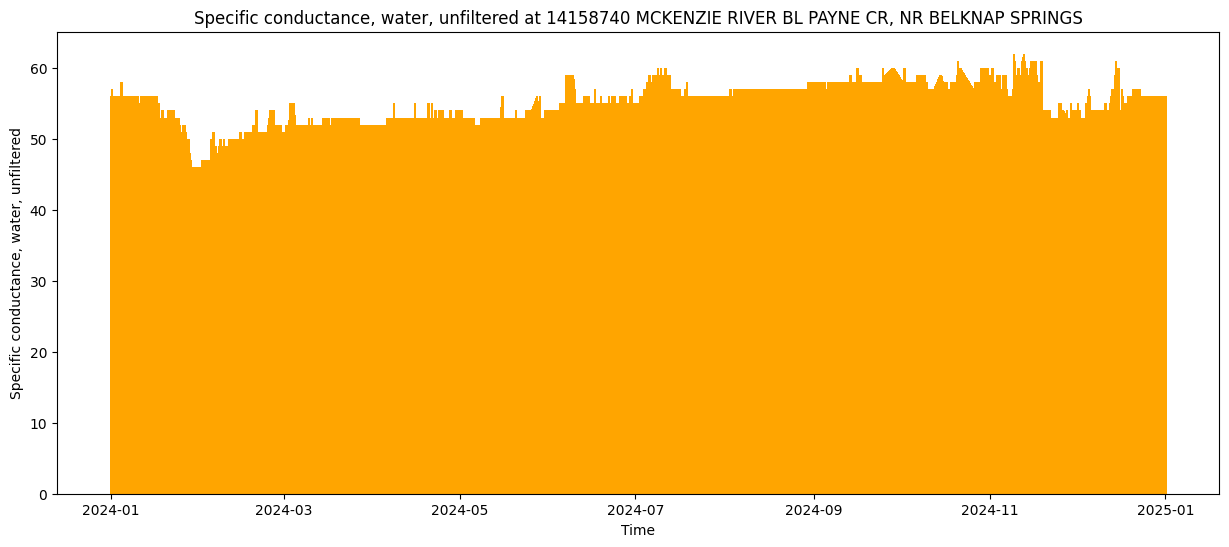

14158850 MCKENZIE R BLW TRAIL BR DAM NR BELKNAP SPRINGS Specific conductance, water, unfiltered


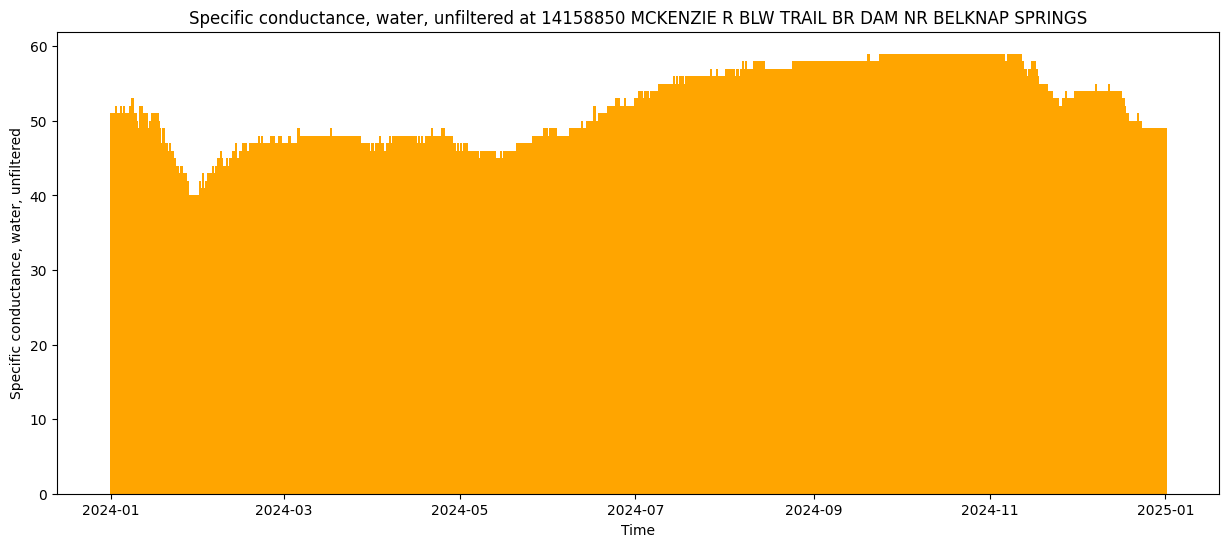

14163150 MCKENZIE RIVER BLW LEABURG DAM, NR LEABURG Specific conductance, water, unfiltered


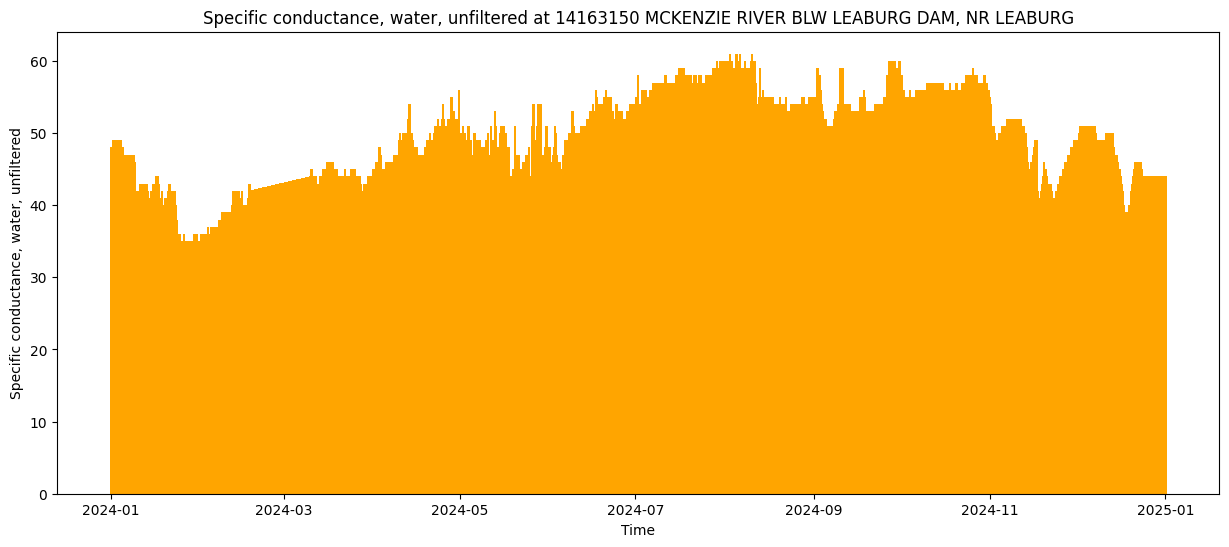

14164900 McKENZIE RIVER ABV HAYDEN BR, AT SPRINGFIELD Specific conductance, water, unfiltered


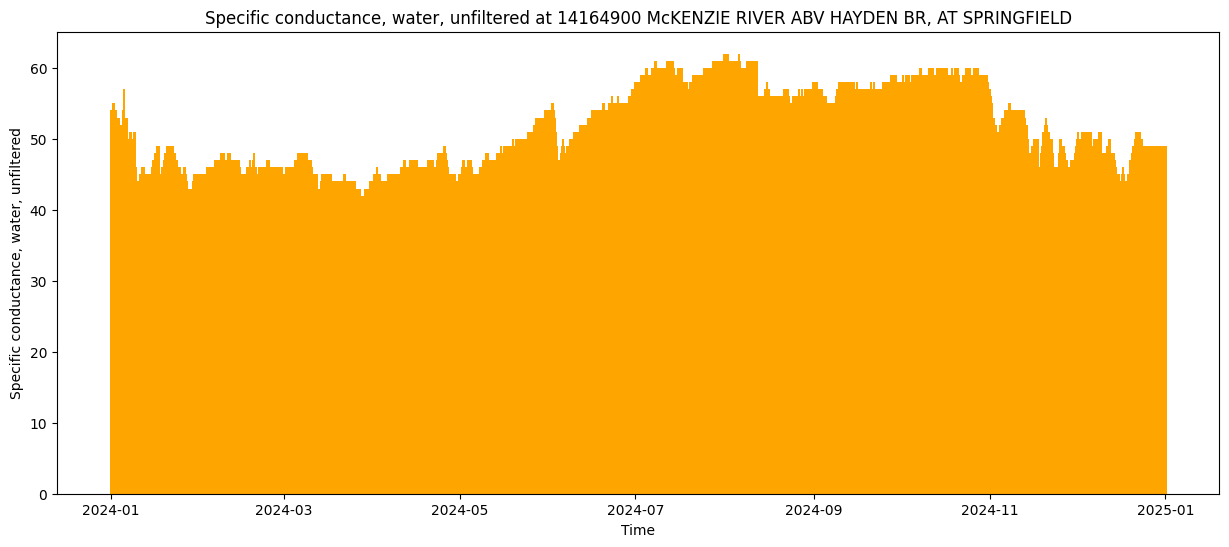

14158500 MCKENZIE RIVER AT OUTLET OF CLEAR LAKE Temperature, water


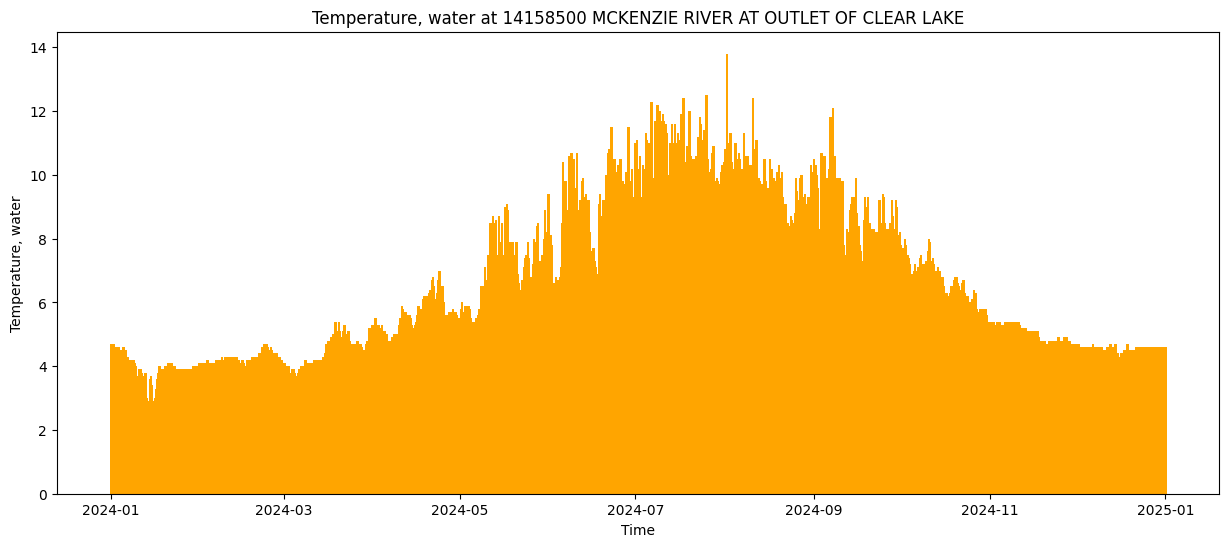

14158740 MCKENZIE RIVER BL PAYNE CR, NR BELKNAP SPRINGS Temperature, water


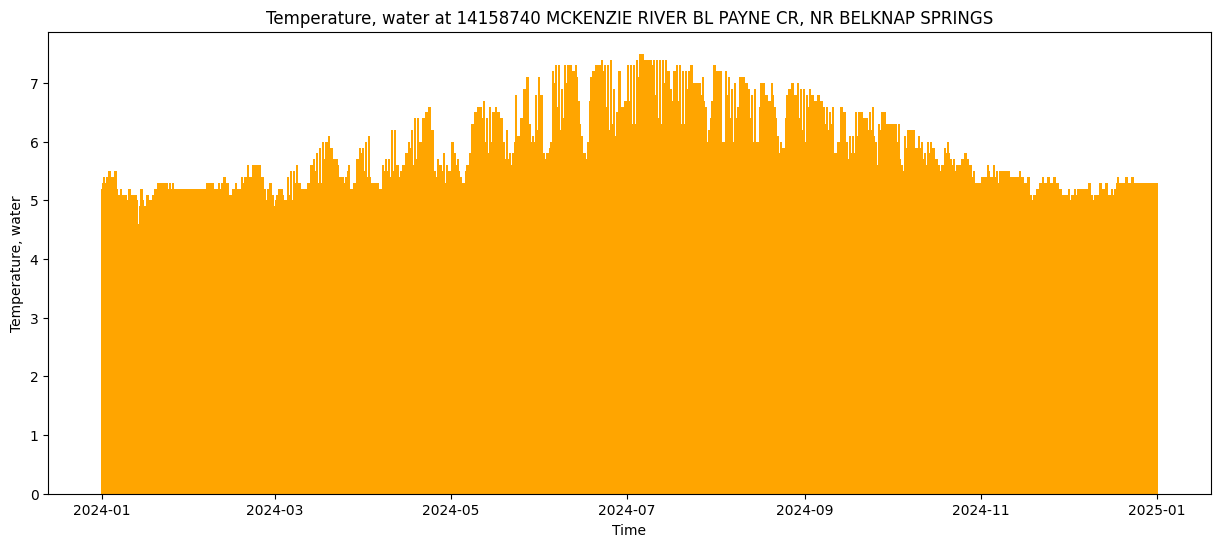

14158850 MCKENZIE R BLW TRAIL BR DAM NR BELKNAP SPRINGS Temperature, water


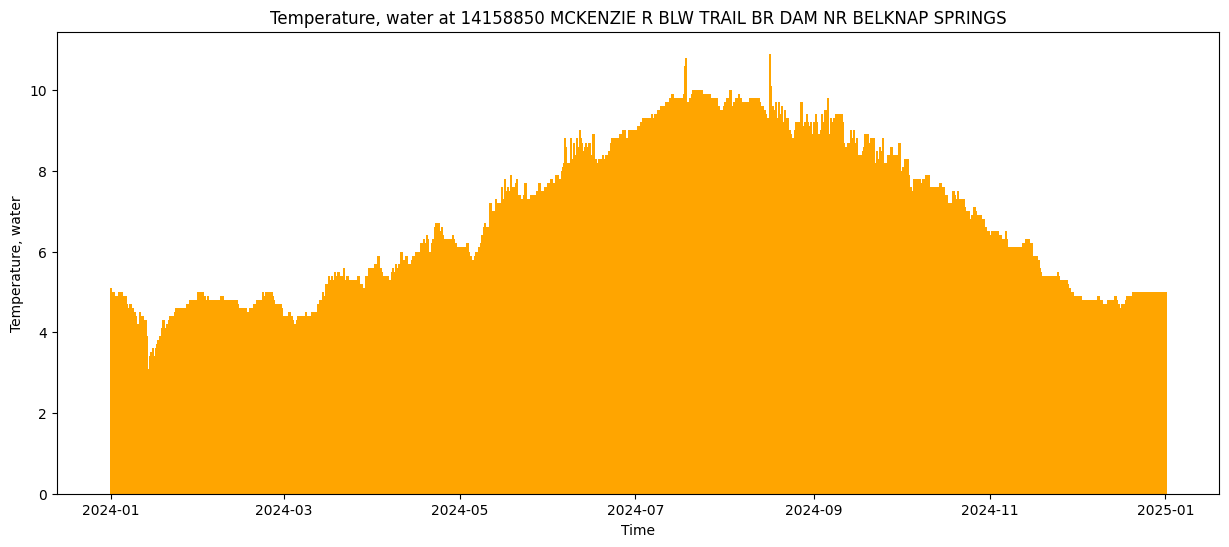

14159130 SF MCKENZIE RIVER ABV ROARING R NR COUGAR DAM Temperature, water


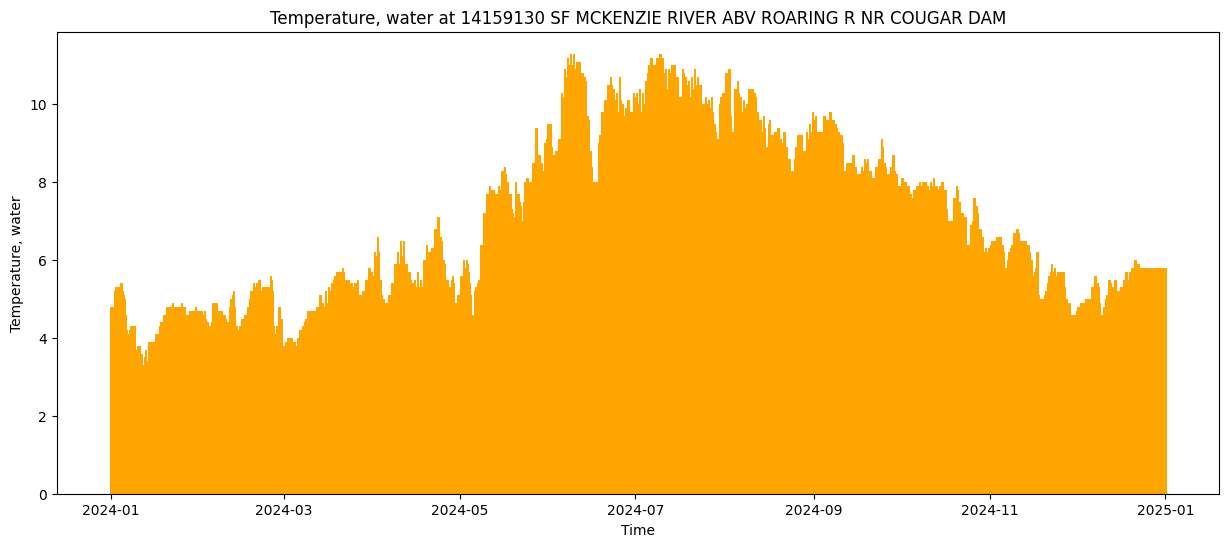

14159200 SO FK MCKENZIE RIVER ABV COUGAR LAKE NR RAINBOW Temperature, water


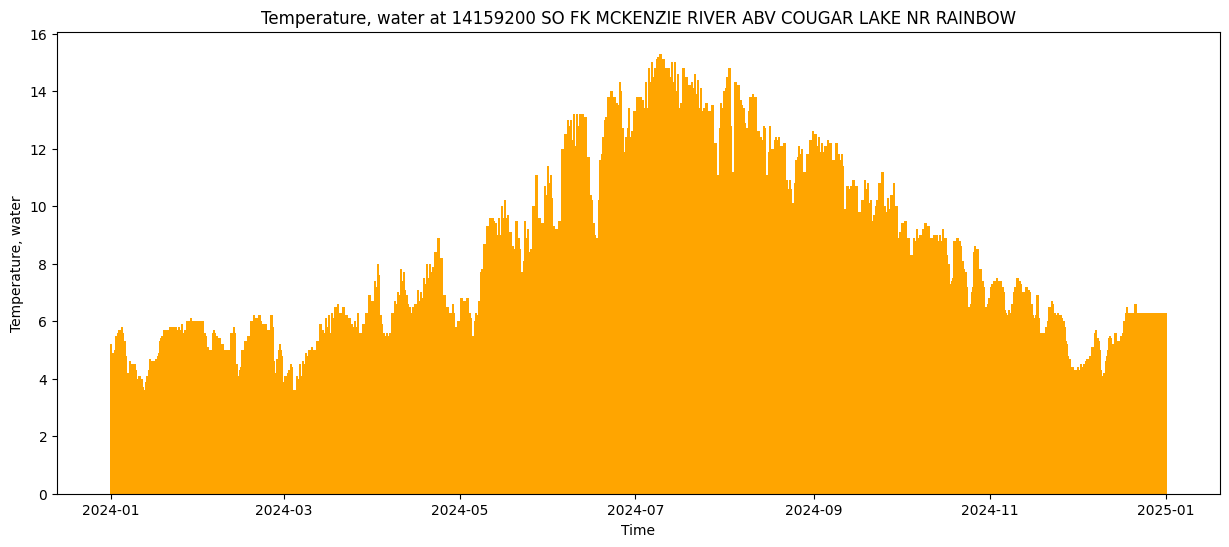

14159500 SOUTH FORK MCKENZIE RIVER NEAR RAINBOW Temperature, water


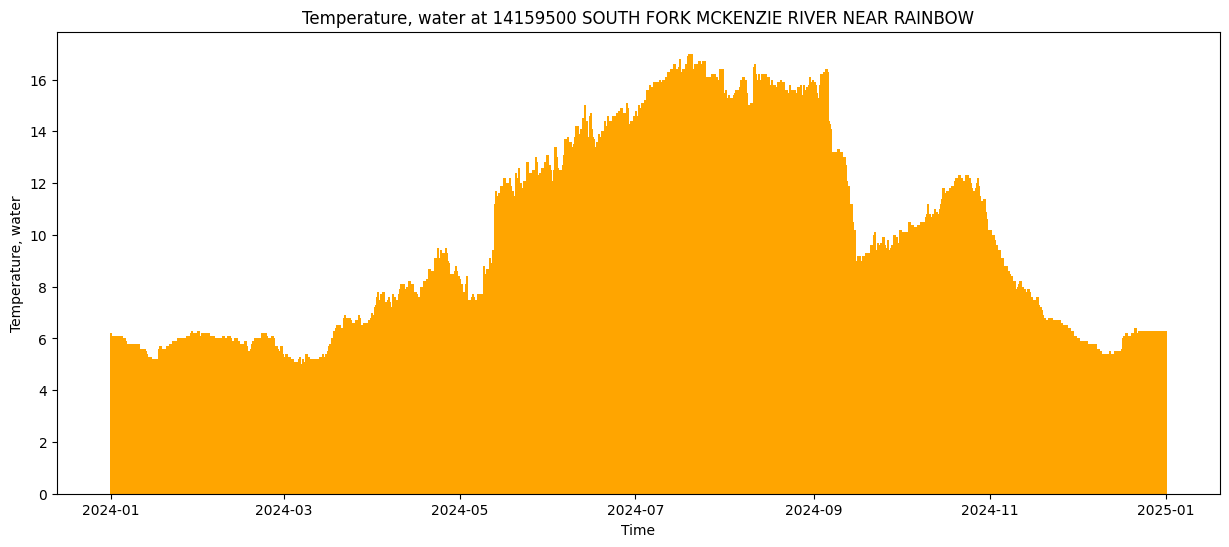

14162500 MCKENZIE RIVER NEAR VIDA Temperature, water


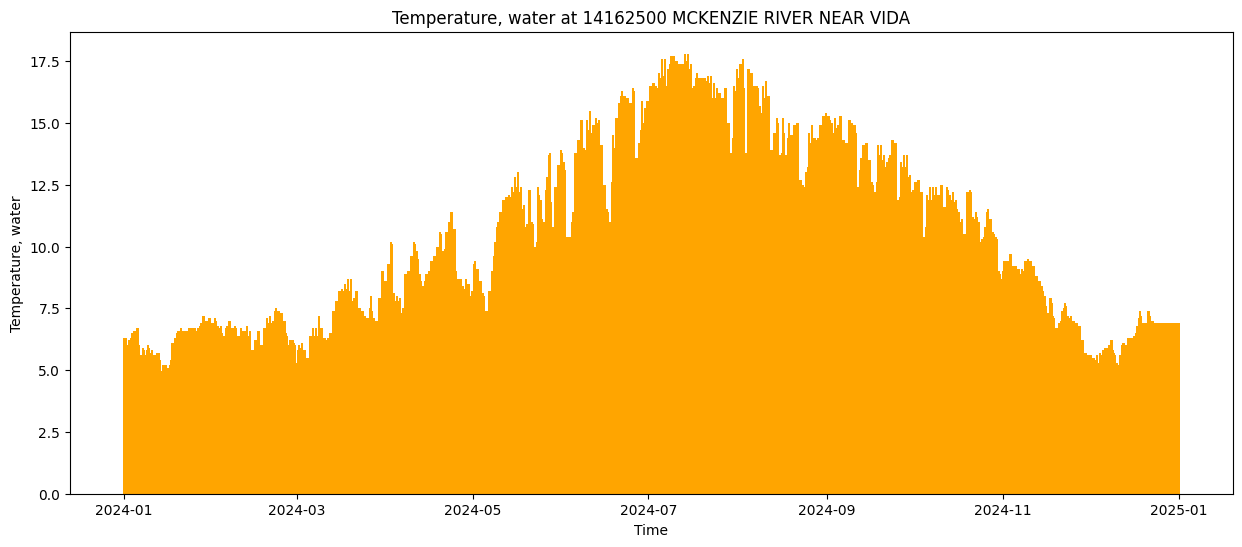

14163150 MCKENZIE RIVER BLW LEABURG DAM, NR LEABURG Temperature, water


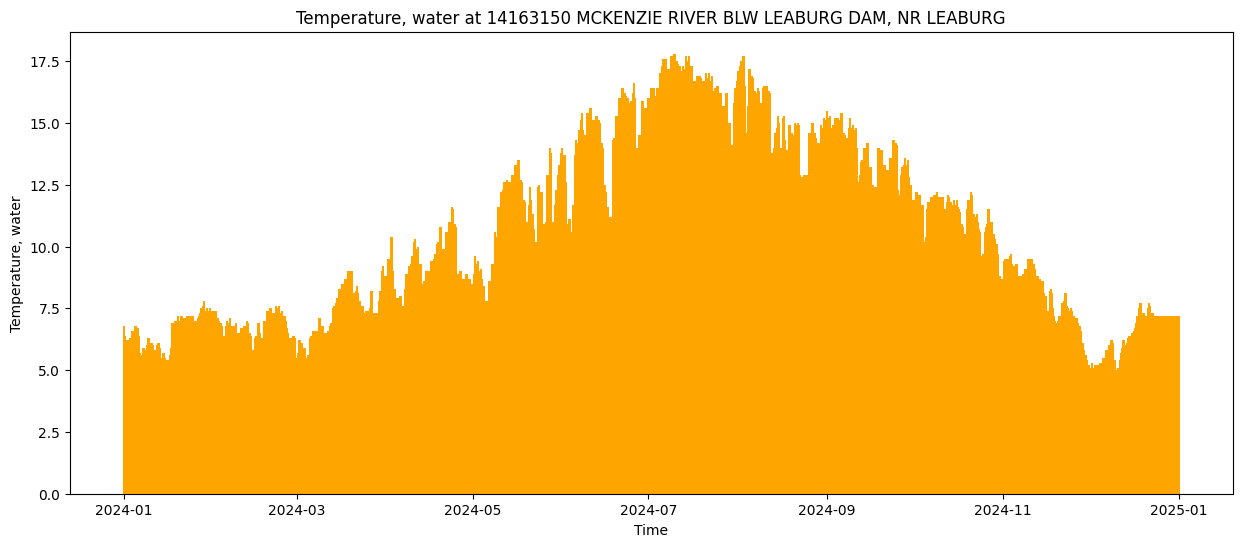

14163900 MCKENZIE RIVER NEAR WALTERVILLE Temperature, water


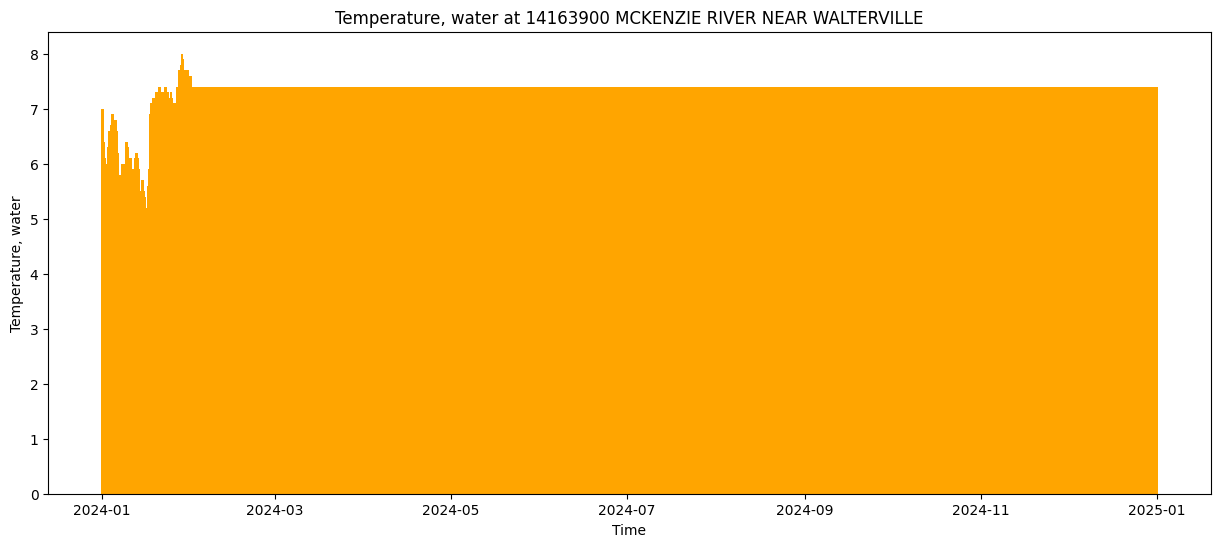

14164900 McKENZIE RIVER ABV HAYDEN BR, AT SPRINGFIELD Temperature, water


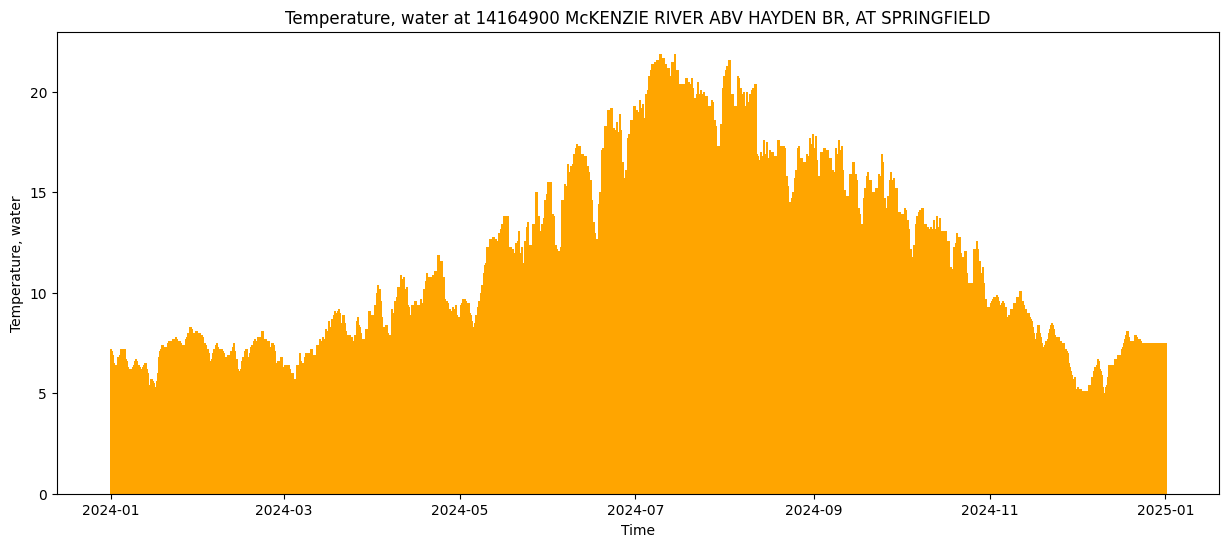

14165500 MCKENZIE RIVER NEAR COBURG Temperature, water


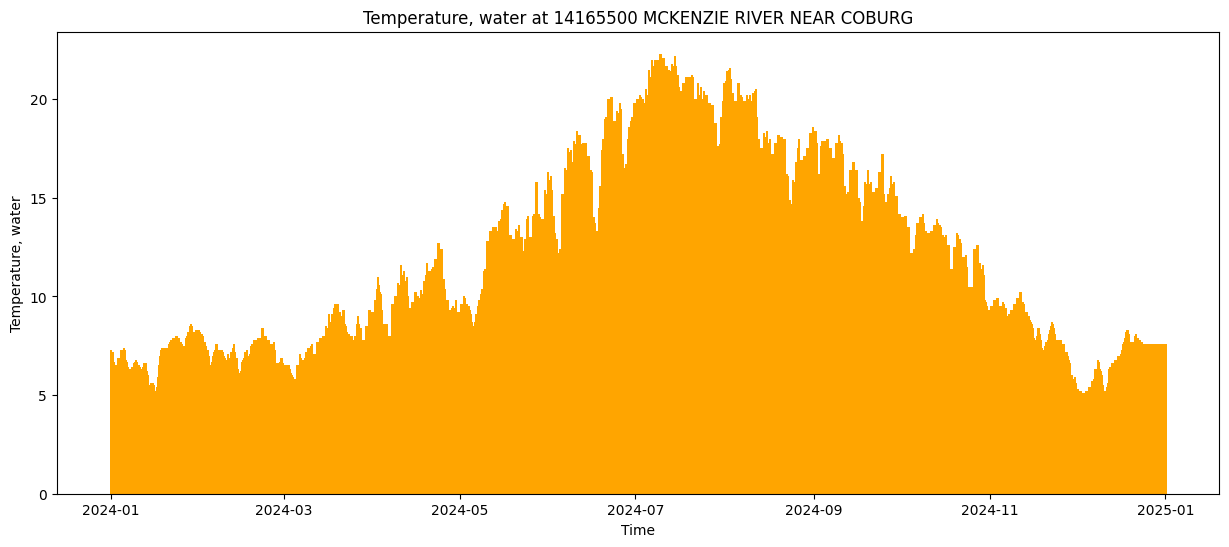

14159500 SOUTH FORK MCKENZIE RIVER NEAR RAINBOW Total partial pressure of dissolved gases, water, unfiltered


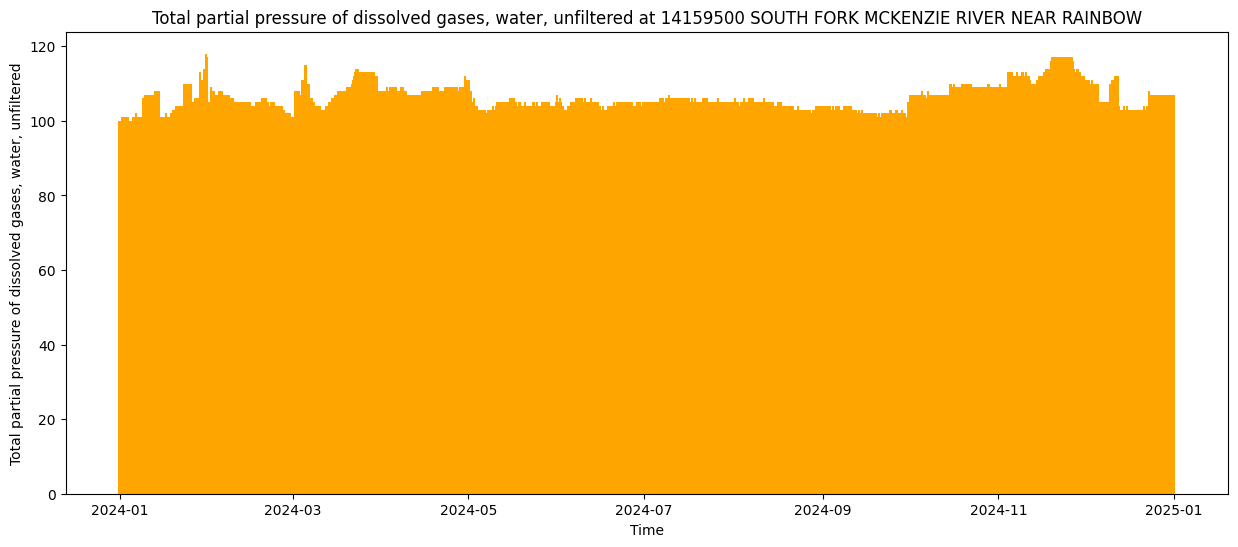

In [12]:
for excel_file in os.listdir(excel_data_path):
    USGS = excel_file.split('.')[0].split('_')[-2]
    station = excel_file.split('.')[0].split('_')[2:][0]
    for i in range(len(excel_file.split('.')[0].split('_')[2:])-1):
        station += "_" + excel_file.split('.')[0].split('_')[2:][i]
    substance = excel_file.split('.')[0].split('_')[:-2][0]
    print(USGS, station, substance)
    try:
        df = pd.read_excel(excel_data_path + excel_file)
        df = df.set_index("Timestamp").reindex(full_time_range).reset_index().rename(columns={"index": "Timestamp"})
        df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
        if (substance == "Discharge"): df["Value"] = df["Value"] * 0.0283168
        elif (substance == "Gage height"): df["Value"] = df["Value"] * 0.3048
        maxval = df["Value"].max()
        minval = df["Value"].min()
        df["Value"] = df["Value"].interpolate(method='linear').bfill().ffill()
        fig = plt.figure(figsize=(15, 6))
        plt.bar(df["Timestamp"], df["Value"], color='orange')
        plt.xlabel('Time')
        if (substance == "Discharge"): plt.ylabel('Discharge')
        elif (substance == "Gage height"): plt.ylabel('Gage Height')
        else: plt.ylabel(substance)
        plt.title(f'{substance} at {USGS} {station}')
        plt.show()
        fig.savefig(f'{output_path_image}/{excel_file.split(".")[0]}.jpg', format='jpg', dpi=500)
        df.to_excel(f'{output_path_excel}/{excel_file}')
    except:
        print(f"FAIL TO FILL {substance} OF {USGS} {station}")